<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [124]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [125]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

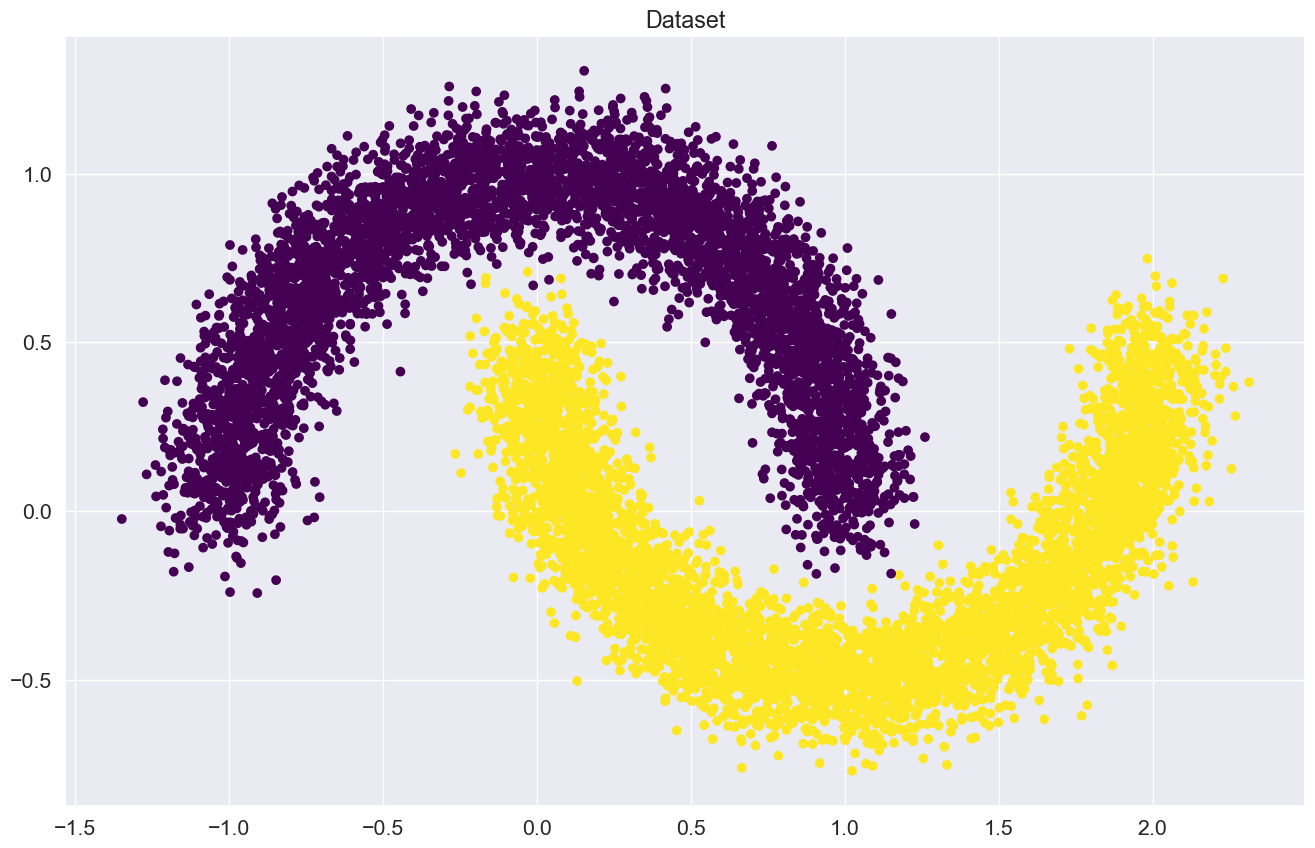

In [126]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [127]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [128]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [129]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [130]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if self.bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))
        else:
            self.bias_term = None

    def forward(self, x):
        x = torch.mm(x, self.weights.t())
        if self.bias is not None:
            x += self.bias_term.view(1, -1)
        return x



In [131]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [132]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

num_params = count_parameters(linear_regression)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [133]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        y_batch = y_batch.view(-1, 1)

        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 64.375
Iteration: 100
Batch accuracy: 64.65625
Iteration: 200
Batch accuracy: 64.3125
Iteration: 300
Batch accuracy: 64.78125
Iteration: 400
Batch accuracy: 64.09375
Iteration: 500
Batch accuracy: 64.015625
Iteration: 600
Batch accuracy: 65.5
Iteration: 700
Batch accuracy: 63.75
Iteration: 800
Batch accuracy: 64.125

Iteration: 877.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 877 iterations

### Визуализируем результаты

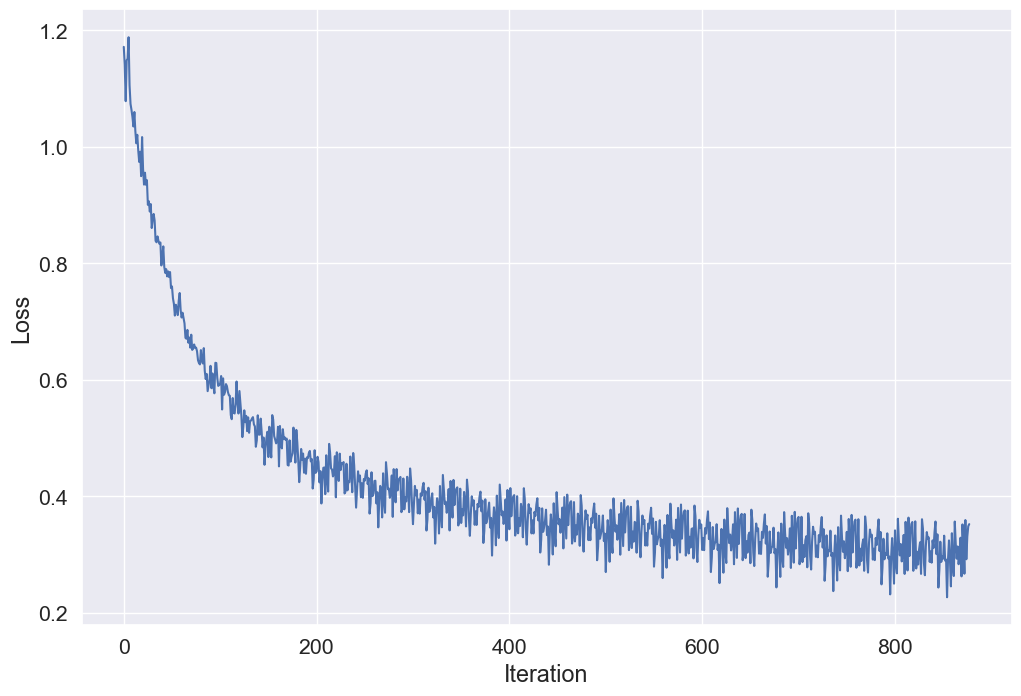

In [134]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

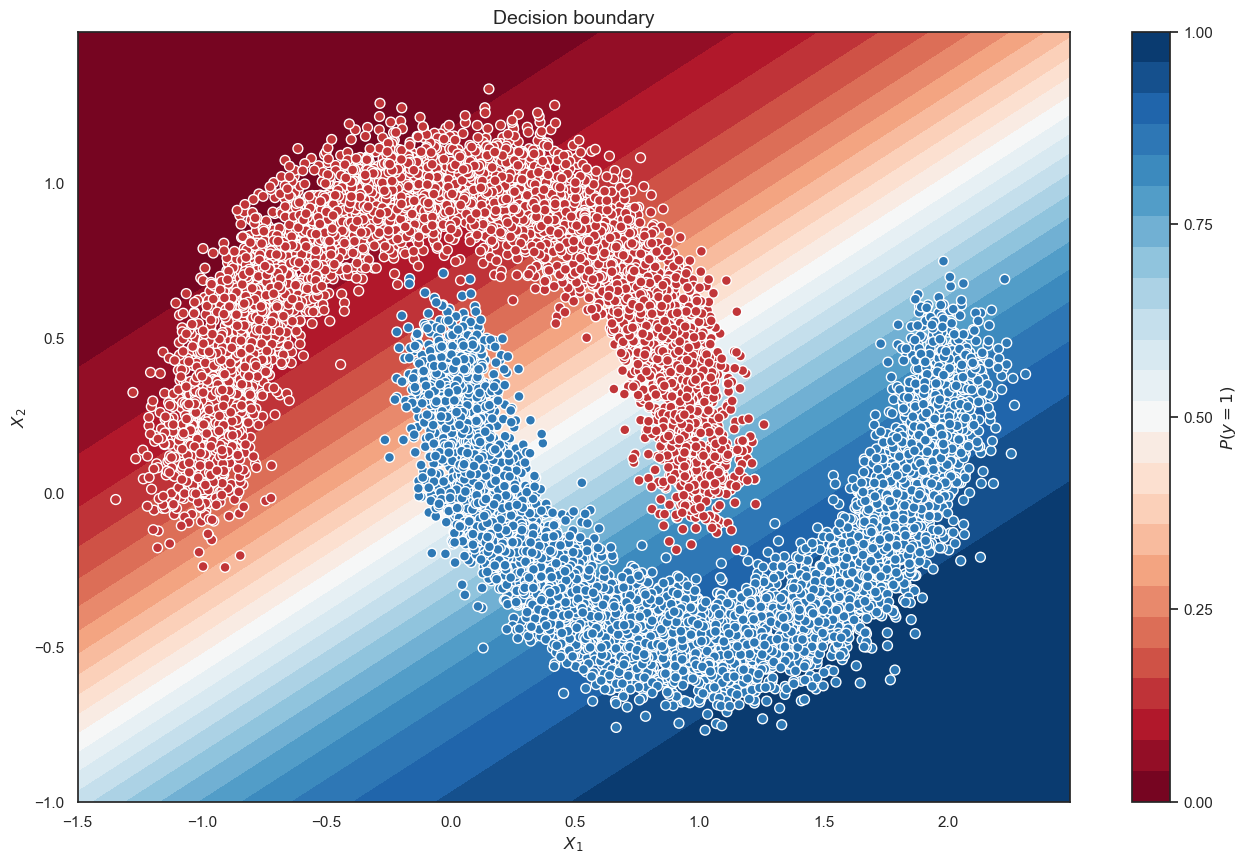

In [135]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [136]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [137]:
from sklearn.metrics import accuracy_score

predicted_labels = predict(val_dataloader, linear_regression)
true_labels = np.array([])

for _, y_batch in val_dataloader:
    true_labels = np.hstack((true_labels, y_batch.numpy().flatten()))

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8592


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.86

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [138]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [139]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [140]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)


In [141]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [142]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [143]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9013333333333333
Loader: valid. Accuracy: 0.9506
Epoch: 2
Loader: train. Accuracy: 0.9537833333333333
Loader: valid. Accuracy: 0.9605
Epoch: 3
Loader: train. Accuracy: 0.9662333333333334
Loader: valid. Accuracy: 0.9636
Epoch: 4
Loader: train. Accuracy: 0.9727666666666667
Loader: valid. Accuracy: 0.9683
Epoch: 5
Loader: train. Accuracy: 0.9771333333333333
Loader: valid. Accuracy: 0.9709
Epoch: 6
Loader: train. Accuracy: 0.9802333333333333
Loader: valid. Accuracy: 0.9684
Epoch: 7
Loader: train. Accuracy: 0.98165
Loader: valid. Accuracy: 0.9709
Epoch: 8
Loader: train. Accuracy: 0.9846333333333334
Loader: valid. Accuracy: 0.9736
Epoch: 9
Loader: train. Accuracy: 0.9847666666666667
Loader: valid. Accuracy: 0.9736
Epoch: 10
Loader: train. Accuracy: 0.98635
Loader: valid. Accuracy: 0.9727


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [145]:
class CustomModel(nn.Module):
    def __init__(self, activation):
        super(CustomModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            activation,
            nn.Linear(128, 128),
            activation,
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

def train_and_validate(model, dataloaders, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_accuracy = []
    valid_accuracy = []

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_corrects = 0
            running_total = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_corrects += torch.sum(preds == labels.data)
                running_total += labels.size(0)

            epoch_acc = running_corrects.double() / running_total

            if phase == 'train':
                train_accuracy.append(epoch_acc)
            else:
                valid_accuracy.append(epoch_acc)

    return train_accuracy, valid_accuracy

def test_activation_function(activation_function_name: str, dataloaders):
    activations = {'Identical': nn.Identity(),
                   'ReLU': nn.ReLU(),
                   'LeakyReLU': nn.LeakyReLU(),
                   'Sigmoid': nn.Sigmoid(),
                   'Tanh': nn.Tanh(),
                   'ELU': nn.ELU()}

    print(f"Testing {activation_function_name} activation function...")
    model = CustomModel(activations[activation_function_name])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    accuracy = train_and_validate(model, dataloaders, criterion, optimizer)

    return accuracy

In [146]:
plain_accuracy = test_activation_function("Identical", loaders)
relu_accuracy = test_activation_function("ReLU", loaders)
leaky_relu_accuracy = test_activation_function("LeakyReLU", loaders)
elu_accuracy = test_activation_function("ELU", loaders)

Testing Identical activation function...
Testing ReLU activation function...
Testing LeakyReLU activation function...
Testing ELU activation function...


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

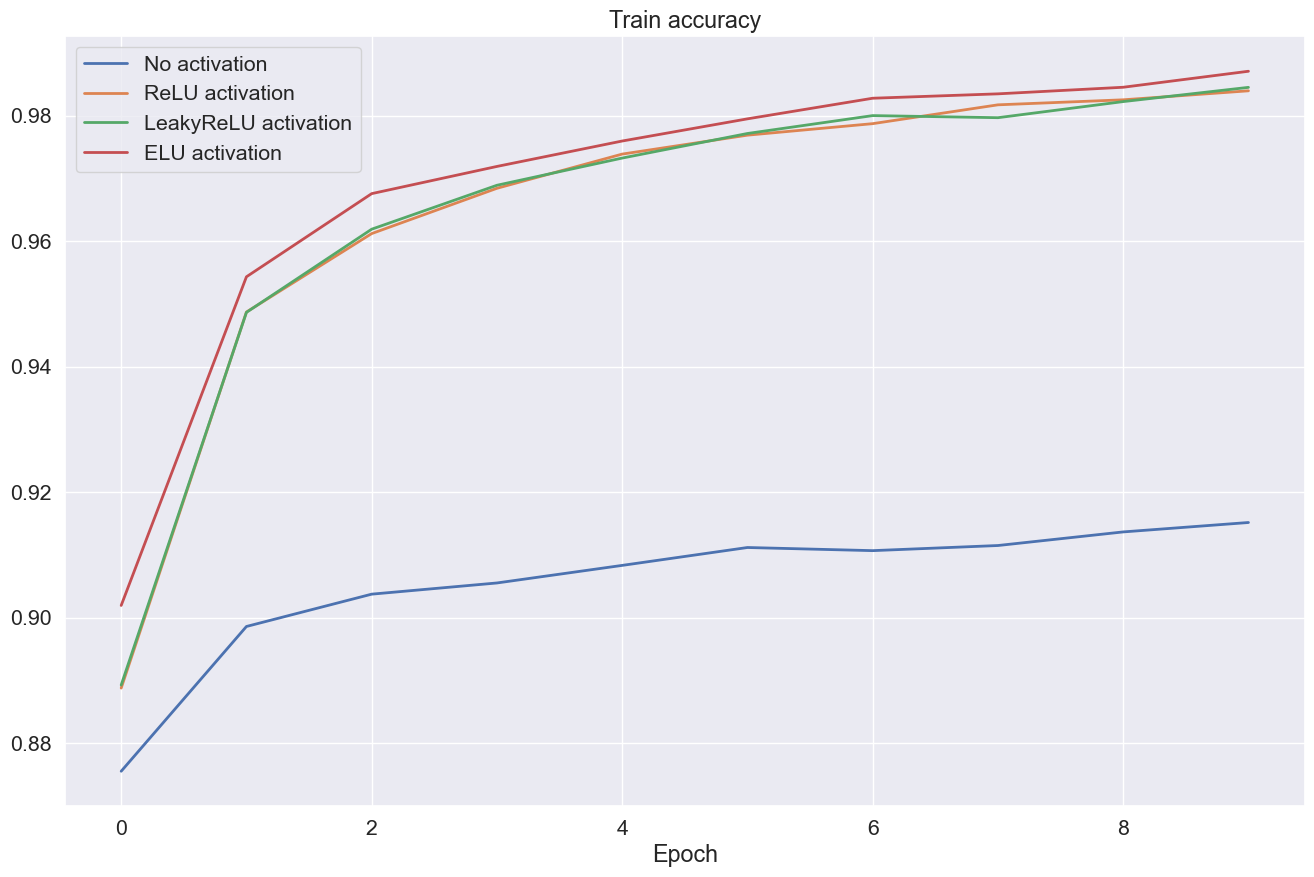

In [147]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Train accuracy")
plt.plot(range(max_epochs), plain_accuracy[0], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy[0], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy[0], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy[0], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

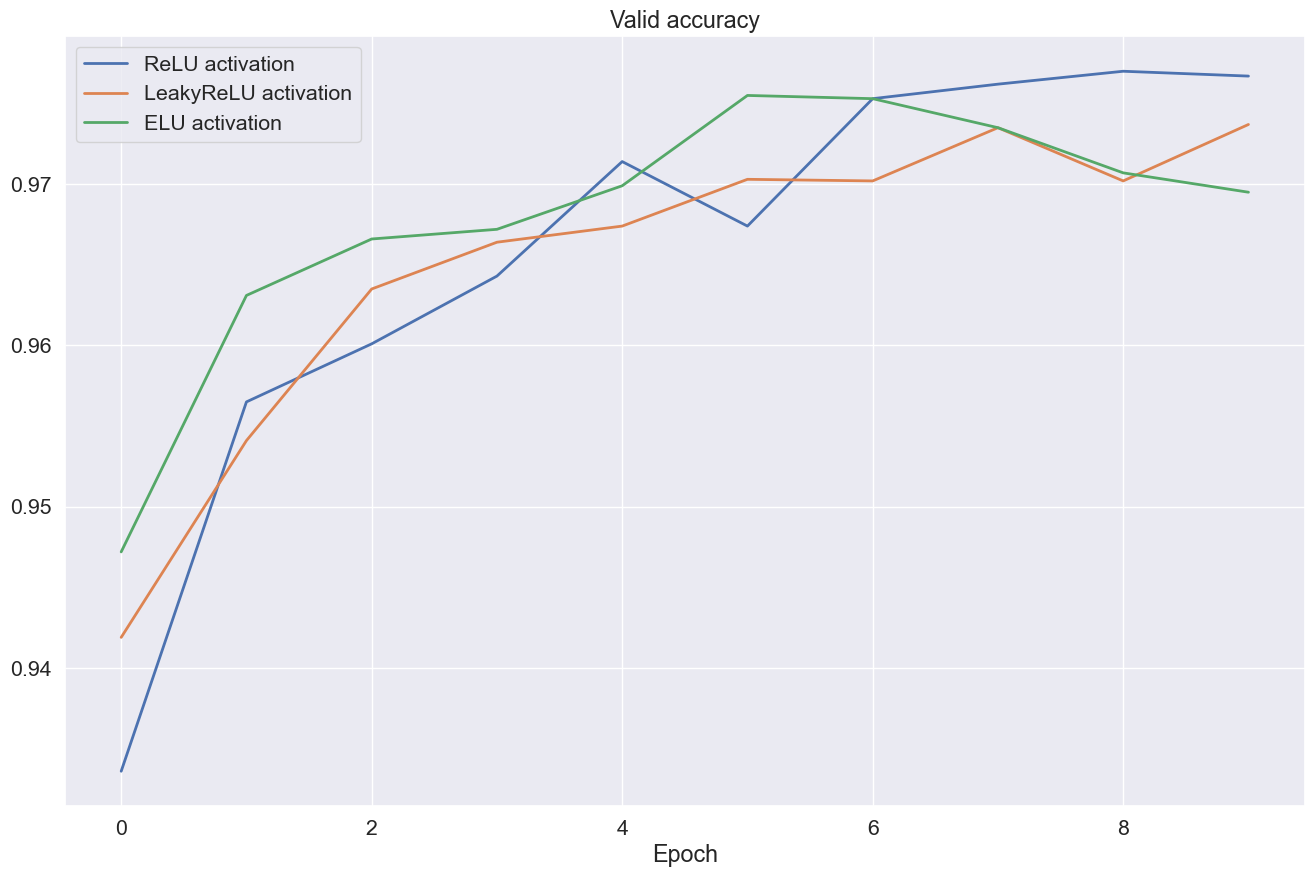

In [148]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy[1], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy[1], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy[1], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [149]:
print(f"Identical Mean Train accuracy: {np.mean(plain_accuracy[0])} Mean Valid accuracy: {np.mean(plain_accuracy[1])}")
print(f"ReLU Mean Train accuracy: {np.mean(relu_accuracy[0])} Mean Valid accuracy: {np.mean(relu_accuracy[1])}")
print(f"Leaky_ReLU Mean Train accuracy: {np.mean(leaky_relu_accuracy[0])} Mean Valid accuracy: {np.mean(leaky_relu_accuracy[1])}")
print(f"ELU Mean Train accuracy: {np.mean(elu_accuracy[0])} Mean Valid accuracy: {np.mean(elu_accuracy[1])}")

Identical Mean Train accuracy: 0.9054283333333334 Mean Valid accuracy: 0.90868
ReLU Mean Train accuracy: 0.9645083333333334 Mean Valid accuracy: 0.9658499999999999
Leaky_ReLU Mean Train accuracy: 0.9645833333333332 Mean Valid accuracy: 0.96512
ELU Mean Train accuracy: 0.9689316666666666 Mean Valid accuracy: 0.96785


In [150]:
print(f"Identical Max Train accuracy: {np.max(plain_accuracy[0])} Max Valid accuracy: {np.max(plain_accuracy[1])}")
print(f"ReLU Max Train accuracy: {np.max(relu_accuracy[0])} Max Valid accuracy: {np.max(relu_accuracy[1])}")
print(f"Leaky_ReLU Max Train accuracy: {np.max(leaky_relu_accuracy[0])} Max Valid accuracy: {np.max(leaky_relu_accuracy[1])}")
print(f"ELU Max Train accuracy: {np.max(elu_accuracy[0])} Max Valid accuracy: {np.max(elu_accuracy[1])}")

Identical Max Train accuracy: 0.9152 Max Valid accuracy: 0.9164
ReLU Max Train accuracy: 0.9839833333333333 Max Valid accuracy: 0.977
Leaky_ReLU Max Train accuracy: 0.9845333333333334 Max Valid accuracy: 0.9737
ELU Max Train accuracy: 0.9871 Max Valid accuracy: 0.9755


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

Identical Mean Train accuracy: 0.91 Mean Valid accuracy: 0.91<br>
ReLU Mean Train accuracy: 0.96 Mean Valid accuracy: 0.97<br>
Leaky_ReLU Mean Train accuracy: 0.96 Mean Valid accuracy: 0.97<br>
ELU Mean Train accuracy: 0.97 Mean Valid accuracy: 0.97<br>

The best result on train and validation dataset is for ELU activation function

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [151]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-10-28 16:15:53--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48,18K  58,7KB/s    in 0,8s    

2023-10-28 16:15:56 (58,7 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



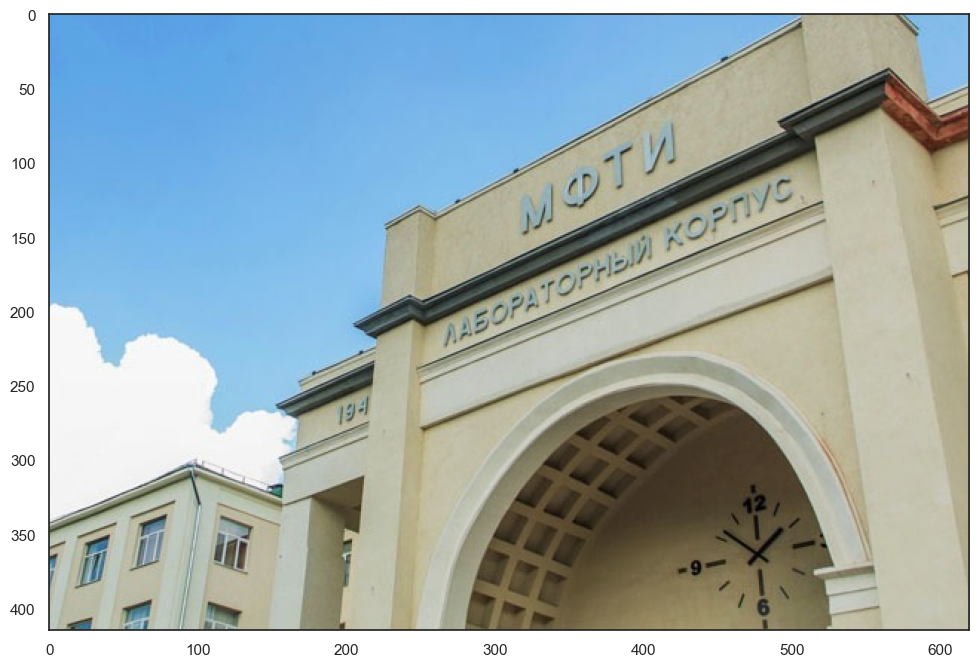

In [152]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [153]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

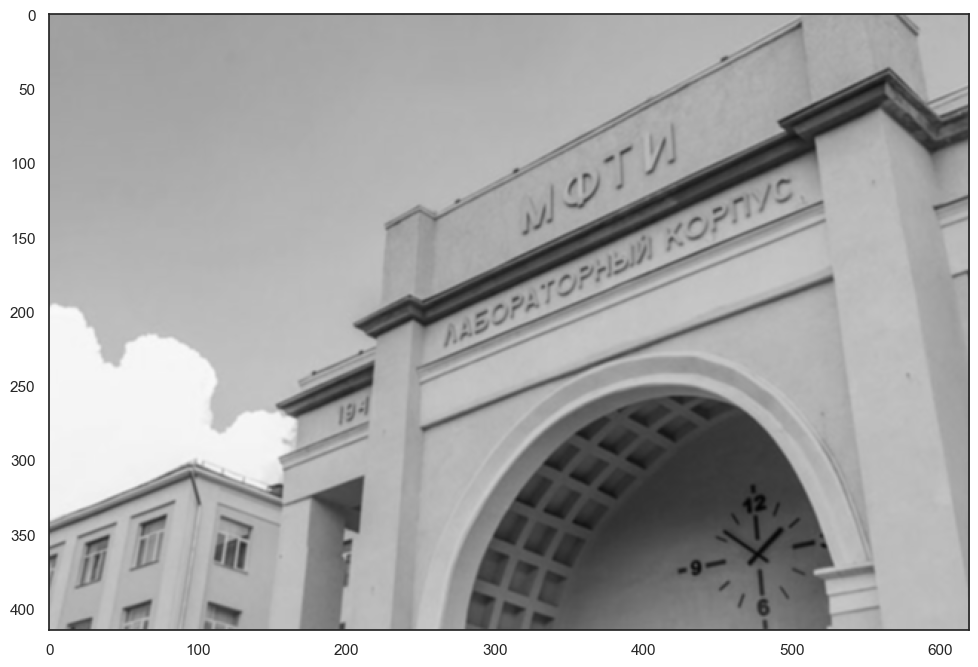

In [154]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [155]:
class LeNet(nn.Module):
    def __init__(self, activation):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.activation = activation

    def forward(self, x):
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

def test_activation_function_lenet(activation_function_name: str, dataloaders):
    activations = {'ReLU': nn.ReLU(),
                   'LeakyReLU': nn.LeakyReLU(),
                   'Sigmoid': nn.Sigmoid(),
                   'Tanh': nn.Tanh(),
                   'ELU': nn.ELU()}

    print(f"Testing {activation_function_name} activation function...")
    model = LeNet(activations[activation_function_name])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    train_accuracy, valid_accuracy = train_and_validate(model, dataloaders, criterion, optimizer)

    return train_accuracy, valid_accuracy

In [156]:
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [157]:
lenet_accuracy = test_activation_function_lenet("ELU", loaders)

Testing ELU activation function...


Сравним с предыдущем пунктом

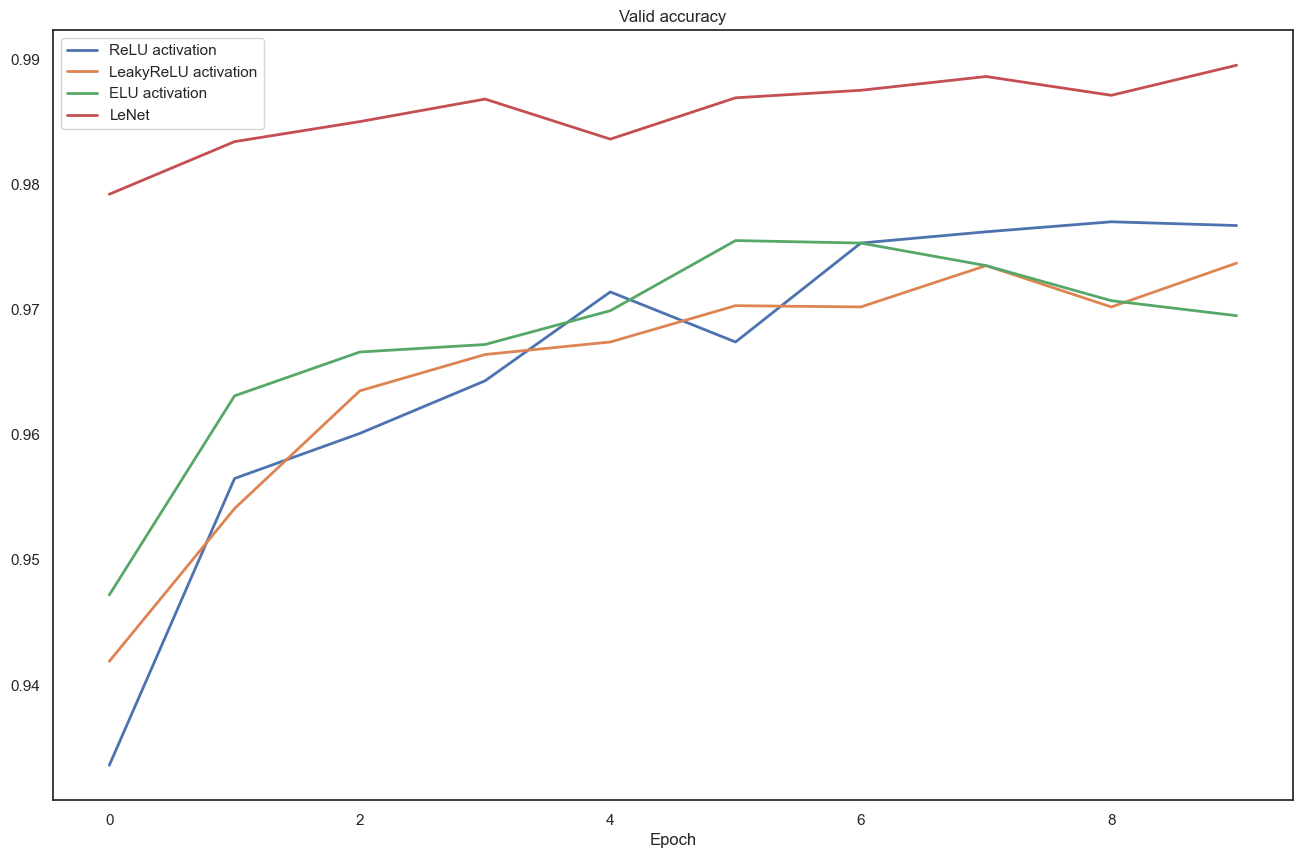

In [158]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy[1], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy[1], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy[1], label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy[1], label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [159]:
print(f"ReLU Mean Train accuracy: {np.mean(relu_accuracy[0])} Mean Valid accuracy: {np.mean(relu_accuracy[1])}")
print(f"Leaky_ReLU Mean Train accuracy: {np.mean(leaky_relu_accuracy[0])} Mean Valid accuracy: {np.mean(leaky_relu_accuracy[1])}")
print(f"ELU Mean Train accuracy: {np.mean(elu_accuracy[0])} Mean Valid accuracy: {np.mean(elu_accuracy[1])}")
print(f"LeNet ELU Mean Train accuracy: {np.mean(lenet_accuracy[0])} Mean Valid accuracy: {np.mean(lenet_accuracy[1])}")

ReLU Mean Train accuracy: 0.9645083333333334 Mean Valid accuracy: 0.9658499999999999
Leaky_ReLU Mean Train accuracy: 0.9645833333333332 Mean Valid accuracy: 0.96512
ELU Mean Train accuracy: 0.9689316666666666 Mean Valid accuracy: 0.96785
LeNet ELU Mean Train accuracy: 0.98499 Mean Valid accuracy: 0.98576


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

LeNet model with ELU activation function gives 0.99 of mean accuracy on validation dataset